In [1]:
from IPython.display import Image

from segar.mdps import MDP
from segar.sim import Simulator
from segar.tasks.classic_control import CartPoleInitialization, CartPoleTask, CartPoleObservation, from_cartpole_basis
from segar.tools.sample_trajectories import rollout, save_gif

/Users/rdevonhjelm/Code/segar/segar/factors/shapes.py:26: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, Delaunay
/Users/rdevonhjelm/Code/segar/segar/factors/shapes.py:26: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, Delaunay


/Users/rdevonhjelm/miniconda3-x86/envs/segar/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


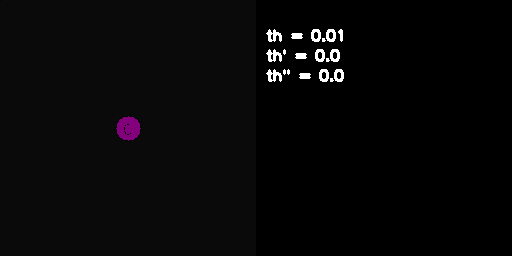

In [2]:
sim = Simulator(friction=0., gravity=9.8, framerate=50)

initialization = CartPoleInitialization()
cartpole_task = CartPoleTask(initialization)
observations = CartPoleObservation()
mdp = MDP(observations, cartpole_task, max_steps_per_episode=200, reset_renderer_every_call=True)
imgs, trajectories = rollout(mdp, show_render=True)

save_gif(imgs, out_path='cartpole.gif')
Image(open('cartpole.gif','rb').read())

In [4]:
import math
from gym.envs.classic_control import CartPoleEnv
import numpy as np

from segar.factors import Position, Velocity
from segar.tasks.classic_control import Angle, AngularVelocity, from_cartpole_basis

sim = Simulator(friction=0., gravity=9.8, framerate=50)

initialization = CartPoleInitialization()
cartpole_task = CartPoleTask(initialization)
observations = CartPoleObservation()
mdp = MDP(observations, cartpole_task, max_steps_per_episode=200, reset_renderer_every_call=True, stop_on_done=False)
cartpole = sim.things['cartpole']

env = CartPoleEnv()
env.kinematics_integrator = None
state = env.reset()
with cartpole.in_place():
    cartpole[Position] = np.array([0., from_cartpole_basis(state[0])])
    cartpole[Velocity] = np.array([0., from_cartpole_basis(state[1], recenter=False)])
    cartpole[Angle] = state[2]
    cartpole[AngularVelocity] = state[3]

assert np.allclose(mdp.observation(mdp.state), state)

for i in range(10):
    action = 0
    s_state = mdp.step(action)[0]
    state = env.step(action)[0]
    assert np.allclose(s_state, state)
